In [39]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import database_utility
import pybaseball

In [2]:
sqlite_file = 'baseball_data.sqlite'
dh = database_utility.DatabaseHelper(sqlite_file)

In [3]:
#This will give a ValueError when using pd.read_json if the path doesn't exist
filepath = r'C:\Users\Chris\Google Drive\Programming\Baseball\Web Scraping\bbref_scraper\bbref_scraper\bbref.jl'

In [4]:
batting_df, pitching_df = dh.pull_raw_bbref_data(filepath)

<h3> Pitching Exploration </h3>

<h4> In FanDuels, pitching is scored based on the following attributes: </h4> 
 - W = 6pts
 - Quality Start = 4pts
 - ER = -3pts
 - SO = 3pts
 - IP = 3pts (1pt per out)
 
 *A quality start is defined as a starting pitcher who completes six innings and permits no more than 3 ER*

Given what we know about the scoring, let's try to calculate what every pitcher's FanDuel score would have been.  This will be a basis for prediction eventually, but for now, we can use it to look at some descriptive statistics.

First, let's create a unique ID column based on Date, Location and Start Time.  This should account for doubleheaders as well.

In [5]:
#clean up the date column to prepare creating a unique ID
pitching_df['Day of Week'], pitching_df['game_date'] = pitching_df['game_date'].str.split(',', 1).str
pitching_df['game_date'] = pd.to_datetime(pitching_df['game_date'], infer_datetime_format=True)
pitching_df['year'] = pitching_df['game_date'].map(lambda x : x.year)
pitching_df['year'] = pitching_df['year'].astype('int')

#clean up start time strings
clean_times = []
for time in pitching_df['start_time'].str.split(': '):
    try:
        clean_times.append(time[1].split(' L')[0])
    except IndexError:
        clean_times.append("unknown_start_time")
        
pitching_df['start_time'] = clean_times

Now the actual unique ID column

In [6]:
id_col = pitching_df['game_date'].astype(str) + pitching_df['location'] + pitching_df['start_time'] + pitching_df['player']
pitching_df.insert(loc=0, column='game_id', value=id_col)

Ok so now we can set about trying to create a column that represents what the FanDuel score for that player for a given day would be.  We can group on the unique game ID and the pitcher name to get stats for each pitcher for a game.

We want to do some error checking - for example, the most earned runs a pitcher has ever given up in the modern era is 14.

In [ ]:
#if ER is above 15, set it equal to 0 as it's likely a mistake
pitching_df['ER'] = pd.to_numeric(pitching_df['ER'])
pitching_df.loc[pitching_df['ER'] > 14]['ER'] = 0

#we will do the same for innings pitched - assuming it should be a max of 9, which is a complete game
#this induces some NA's which we will drop at the end
pitching_df['IP'] = pd.to_numeric(pitching_df['IP'], errors='coerce')
pitching_df.loc[pitching_df['IP'] > 0]['IP'] = 0.0

#same for strikeouts
pitching_df['SO'] = pd.to_numeric(pitching_df['SO'], errors='coerce')

#a win is indicated in a weird column - it's pulled from a text scrape on Baseball Reference thats in the same spot as the position for batters, which is why the column is called 'position'
#if the string in this column contains a 'W', we can say this pitcher got a win

#first convert NaNs to string so we can search using str.contains
pitching_df['position'] = pitching_df['position'].fillna("NA")
#then set a flag it was a win
pitching_df.loc[pitching_df['position'].str.contains('W'), 'win_recorded'] = 1
#fill the non wins with 0
pitching_df['win_recorded'] = pitching_df['win_recorded'].fillna(0)

To determine quality starts, we need to see if a pitcher was the starting pitcher.  The easiest way is to flag whether or not they were the first pitcher listed for a game

In [11]:
#there is probably a better way to do this but
#first group and find the first pitcher of each game
qual_start_df = pitching_df.groupby(['game_date', 'location', 'start_time', 'team'])['player'].first().reset_index()
#then create a new id column we will join back to the original df on.  we want an ID for the game itself, not specific to the player
qual_start_df['first_pitch_id'] = qual_start_df['game_date'].astype(str) + qual_start_df['location'] + qual_start_df['start_time']
#we need to create this ID in the other df too
pitching_df['first_pitch_id'] = pitching_df['game_date'].astype(str) + pitching_df['location'] + pitching_df['start_time']

#take the subset of just the two columns we need - rename player so it doesn't duplicate
qual_start_df = qual_start_df[['first_pitch_id', 'player']]
qual_start_df.columns = ['first_pitch_id', 'first_pitcher']

#join it back to the original df
pitching_df = pd.merge(pitching_df, qual_start_df, on='first_pitch_id')

#create a bool column to indicate if this was the starting pitcher
pitching_df.loc[pitching_df['player'] == pitching_df['first_pitcher'], 'is_first_pitcher'] = 1
pitching_df.loc[pitching_df['player'] != pitching_df['first_pitcher'], 'is_first_pitcher'] = 0

#lets clean up the dataframe and get rid of unneeded columns
pitching_df.drop(['first_pitcher', 'first_pitch_id'], axis=1, inplace=True)
#clean up memory
del qual_start_df

Alright!  So there are some stats we can just easily aggregate to calculate the final score.  

However, finding quality starts is slightly harderd - a game is a quality start if it was a starting pitcher, IP > 6 and ER < 3

In [12]:
#find the quality starts using boolean filters
qual_start_df = pitching_df[(pitching_df['ER'] <= 3) & (pitching_df['is_first_pitcher'] == 1) & (pitching_df['IP'] >= 6)]
qual_start_df['quality_start'] = 1
#take only the columns we need
qual_start_df = qual_start_df[['game_id', 'quality_start']]

#merge back in to the original df, left join to keep all the original rows
pitching_df = pd.merge(pitching_df, qual_start_df, on='game_id', how='left')
pitching_df['quality_start'] = pitching_df['quality_start'].fillna(0)

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ok, now lets go ahead and get the other stats!

In [174]:
stats_df = pitching_df.groupby(['game_id', 'team', 'player']).agg({'IP' : 'max', \
                                                                   'ER' : 'max', \
                                                                   'SO' : 'max', \
                                                                   'win_recorded' : 'max', \
                                                                  'quality_start' : 'max' \
                                                                  }).reset_index()[['game_id', 'IP', 'ER', 'SO', 'win_recorded', 'quality_start']]

We can write a function that can be applied to the dataframe to calculate what the FanDuel score for that pitcher would have been in the game!

In [9]:
def fan_duel_pitching_score(row):
    #IP are worth 3 points per completed inning
    
    #so if ip is 4.2, this will split and do:
    #4*3 + 2 = 14 points
    ip = str(row['IP']).split('.')
    #first value is completed innings
    ip_pts = int(ip[0])*3
    #add the fractional value which should be 0,1,2
    ip_pts += int(ip[1])
    
    #SO are a straight 3 points per SO
    so_pts = row['SO']*3
    
    #ER are negative 3 points per 1 ER
    er_pts = -(row['ER']*3)
    
    #a win is worth 6 points
    win_pts = row['win_recorded']*6
    
    #and a quality start is worth 4 points
    qual_start_pts = row['quality_start']*4
    
    return ip_pts+so_pts+er_pts+win_pts+qual_start_pts

And we can apply it to the dataframe

In [13]:
pitching_df['fd_score'] = pitching_df.apply(fan_duel_pitching_score, axis=1)

<h3> Variability in FanDuel Scores for Pitchers </h3>

FanDuels highly overvalues starting pitching (saves aren't given points) - so let's restrict to just starting pitchers

In [48]:
starting_pitch_stats = pitching_df[pitching_df['is_first_pitcher'] == 1][['game_id', 'year', 'game_date', 'player', 'IP', 'SO', 'ER', 'win_recorded', 'quality_start', 'fd_score']]

starting_pitch_stats['fd_score'].describe()

count    6264.00000
mean       26.31242
std        17.00575
min       -22.00000
25%        14.00000
50%        27.00000
75%        39.00000
max        85.00000
Name: fd_score, dtype: float64

In [53]:
import seaborn as sns

<h5> The distribution for all FD Score's over time looks like it approximates a normal distribution </h5>

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


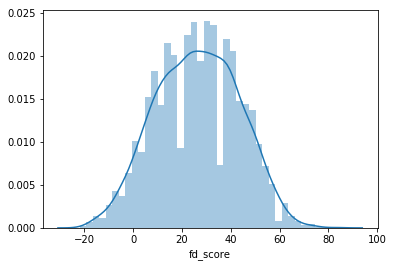

In [260]:
sns.distplot(starting_pitch_stats['fd_score'])

But we can see that when we plot one pitchers performance over a year, even a very good pitcher, their daily performance is highly variable.

In [45]:
sev_stats = pitching_df[(pitching_df['player'] == 'severlu01') & (pitching_df['year'] == 2017)][['game_date', 'fd_score']]
sev_stats = verl_stats.drop_duplicates()

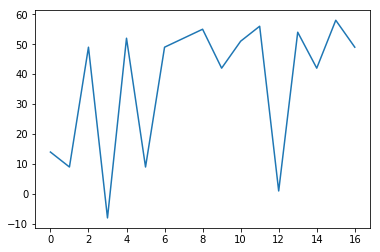

In [44]:
from matplotlib import pyplot as plt

x = np.array([i for i in range(len(verl_stats))])
y = verl_stats['fd_score']

plt.plot(x, y)

But on any given day, there are some pitchers that do well and some pitchers that do poorly, as we might expect.  The goal will be identifying if a pitcher is likely to do well on a specific day

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


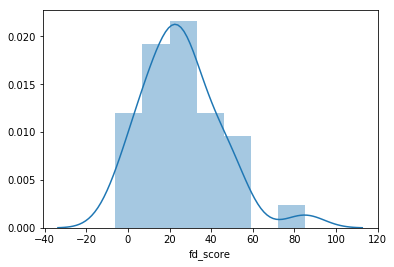

In [54]:
date = '2016-09-17'
one_day = starting_pitch_stats[starting_pitch_stats['game_date'] == date]
sns.distplot(one_day['fd_score'])

Pitchers also vary in their variability.  Std deviation across all pitchers is 14, but in a given year some pitchers are much more consistent.

In [261]:
var_df = starting_pitch_stats.groupby(['player', 'year']).agg({'fd_score' : ['std','sum']}).reset_index()
var_df = var_df.fillna(0)
var_df.columns = ['player', 'year', 'std', 'sum']

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


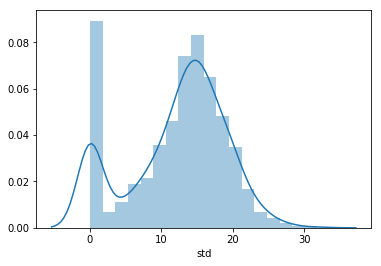

In [262]:
sns.distplot(var_df['std'])

We can see this also by looking at top pitchers - Corey Kluber is a top performer that is highly variable on a per game basis.  Jacob DeGrom has a sd < 10, but a high aggregate score. 

In [263]:
var_df.sort_values(by=['sum', 'std'], ascending=False)[0:25]

,player,year,std,sum
759,verlaju01,2017,11.571289,918.0
374,klubeco01,2016,15.246321,792.0
375,klubeco01,2017,20.052847,774.0
397,lestejo01,2016,11.304606,747.0
648,scherma01,2016,14.875035,692.0
758,verlaju01,2016,11.772850,687.0
760,verlaju01,2018,18.575970,676.0
156,degroja01,2018,9.631679,669.0
436,marquge01,2018,13.578425,654.0
656,severlu01,2017,22.304049,634.0


<h3> Example of pulling statcast data </h3>

In [3]:
%%time
raw_data = dh.pull_raw_data(start_date='2018-05-01', end_date='2018-05-30')
player_df = dh.load_player_lookup_df()

Wall time: 10 s


In [37]:
player_df[player_df['key_bbref'] == 'yateski01']

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
2185,yates,kirby,489446,yatek001,yateski01,9073,2014.0,2018.0
